# Part 4 solutions (don't peek!)

_(Solutions for [Part 4 project](project.ipynb).)_

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import awkward as ak

## Re-reading the dataset

For brevity, let's load the dataset with only the columns we need.

In [2]:
taxi = ak.from_parquet(
    "https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet",
    columns=["trip.km", "trip.begin.l*", "trip.path.*"],
    row_groups=[0],
)
taxi

<Array [[{trip: {...}}, ..., {...}], ...] type='353 * var * ?{trip: {km: ?f...'>

<br><br><br>

## Longitude, latitude → kilometers

Reproducing the conversion from longitude, latitude differences to absolute positions to kilometers.

In [3]:
all_longitudes = taxi.trip.begin.lon + taxi.trip.path.londiff
all_latitudes = taxi.trip.begin.lat + taxi.trip.path.latdiff

all_longitudes

<Array [[[-87.7, -87.7], ..., [...]], ...] type='353 * var * option[var * f...'>

In [4]:
LONGITUDE, LATITUDE = -87.66178320769112, 41.896777262111726   # mean position (center of town)
LON_TO_KM, LAT_TO_KM = 82.98452409203695, 111.07127961503745   # lon, lat → km conversion factors

In [5]:
km_east, km_north = (
    (all_longitudes - LONGITUDE) * LON_TO_KM,
    (all_latitudes - LATITUDE) * LAT_TO_KM,
)

<br><br><br>

## Single path example for comparison

This imperative `for` loop calculation on a single path was given in the problem statement.

I'm repeating it here so that we can compare it with the final answer (always a good idea!).

In [6]:
example_east, example_north = (
    km_east[75, -2],
    km_north[75, -2],
)

length = 0
for i in range(len(example_east) - 1):
    Δx = example_east[i + 1] - example_east[i]
    Δy = example_north[i + 1] - example_north[i]
    Δr = np.sqrt(Δx**2 + Δy**2)
    length += Δr

length

np.float64(7.30448400458981)

<br><br><br>

## THE SOLUTION

Here is a one-line calculation of all the distances of all the paths, maintaining path structure.

In [7]:
distances = ak.sum(np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 + (km_north[:, :, 1:] - km_north[:, :, :-1])**2), axis=-1)

It has the right type: only a single `var` (same as `trips.km`).

In [8]:
distances.type.show()

353 * var * ?float64


Here are the values that were provided for comparison, to help you know if you got it right.

In [9]:
distances

<Array [[0, 9.63, 6.2, 2.07, ..., 7.27, 0, 0], ...] type='353 * var * ?float64'>

And here's the one distance that had been calculated with a `for` loop. It agrees.

In [10]:
distances[75, -2]

np.float64(7.30448400458981)

<br><br><br>

## As the crow flies solution

There are two ways we could do this, but let's use the padding method.

The answer to

> How would you apply this technique to _deeply_ nested lists?

for both techniques is to use `axis=-1`.

In [11]:
pad_km_east = ak.fill_none(ak.pad_none(km_east, 2, axis=-1), 0, axis=-1)
pad_km_north = ak.fill_none(ak.pad_none(km_north, 2, axis=-1), 0, axis=-1)

The "as the crow flies" solution is similar to the main problem, except that there's no [ak.sum](https://awkward-array.org/doc/main/reference/generated/ak.sum.html) over segments. It's a single segment from item `-1` to item `0`.

In [12]:
crow_flies = np.sqrt((pad_km_east[:, :, -1] - pad_km_east[:, :, 0])**2 + (pad_km_north[:, :, -1] - pad_km_north[:, :, 0])**2)
crow_flies

<Array [[0, 7.82, 4.91, ..., 5.53, 0, 0], ...] type='353 * var * ?float64'>

<br><br><br>

## Plotting differences with the `trip.km` field

The plotting code was given, including the hint of filling missing values with `0` (so that `distances` and `taxi.trip.km` align) and flattening.

Here are the full distances on the horizontal axis and `trip.km` on the vertical axis.

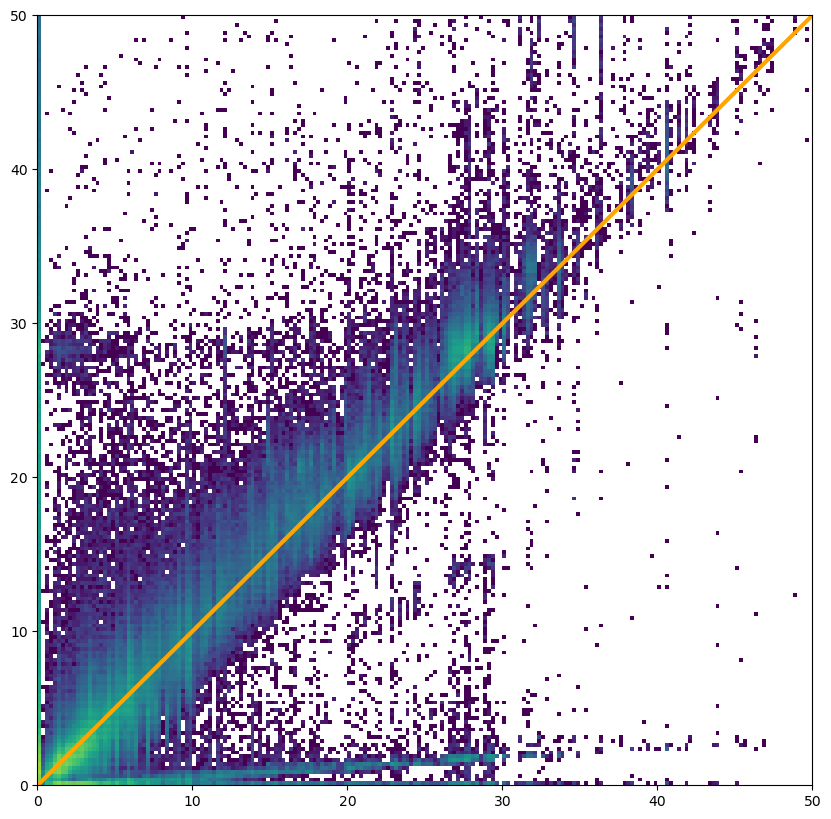

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist2d(
    ak.to_numpy(ak.flatten(ak.fill_none(distances, 0))),    # None → 0 on the plot
    ak.to_numpy(ak.flatten(ak.fill_none(taxi.trip.km, 0))), # None → 0 on the plot
    bins=(200, 200),
    range=((0, 50), (0, 50)),
    norm=matplotlib.colors.LogNorm(),
);
ax.plot([0, 50], [0, 50], c="orange", lw=3);

Here are "as the crow flies" distances on the horizontal axis and `trip.km` on the vertical axis.

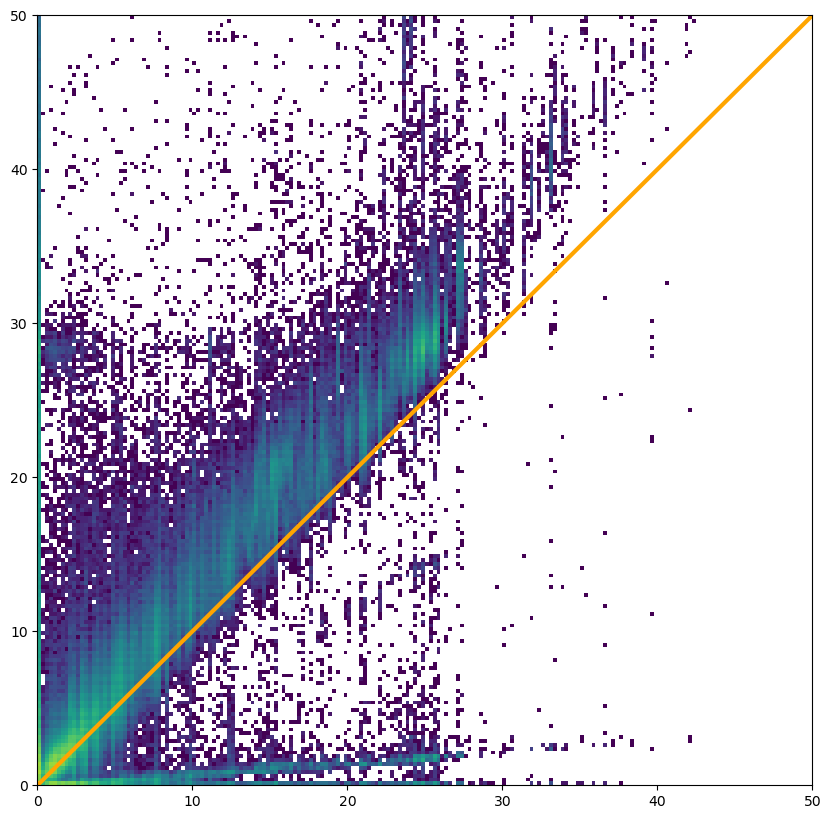

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist2d(
    ak.to_numpy(ak.flatten(ak.fill_none(crow_flies, 0))),   # None → 0 on the plot
    ak.to_numpy(ak.flatten(ak.fill_none(taxi.trip.km, 0))), # None → 0 on the plot
    bins=(200, 200),
    range=((0, 50), (0, 50)),
    norm=matplotlib.colors.LogNorm(),
);
ax.plot([0, 50], [0, 50], c="orange", lw=3);

We should not be surprised that the full path calculations are a better match to reported `trip.km` measurements.

The "as the crow flies" are more fictional: cars don't drive that way.

![](../img/as-the-crow-flies.svg)

However, there are some interesting features on this plot that _I do not understand._

   * There's an island of `trip.km` $\approx$ 29 km with calculated distances $\approx$ 3 km.
   * There's a secondary trend of `trip.km` $\approx$ `distance / 15` along the bottom of each plot. What could that be?

Fun with real data!